- This Notebook is for creating the datasets for the machine learning models
- The notebook has to be run with two different parametersets of the Synthetic_Patient_Dataset class
- threshold = x, actigraphy_data_operator = '-', depression_classifier_feature = 'BP_PHQ_9', percent_of_dataset = 100
- threshold = y, actigraphy_data_operator = '-', depression_classifier_feature = 'MH_PHQ_S', percent_of_dataset = 100

## 1. Import all dependencies

In [1]:
import pandas as pd
import numpy as np
from helpers import *
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from Data_Preprocessing_and_features import *
logging.basicConfig(level = logging.INFO, filename='log.log', filemode='w', format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


- We created a Class called Synthetic_Patient_Dataset containing all the functions that we need for the data processing and feature extraction (Data_Preprocessing_and_feature.py)
- The class takes 4 different inputs
    - threshold that varies
    - actigraphy_data_operator for the operation that is performed on the actigraphy data
    - depression_classifier_feature for MH_PHQ_S or BP_PHQ_9
    - percent of dataset for faster computing
- You have to create a PAM, ALL and data directory
    - PAM and ALL Files are stored in these folders. The data folder is for storing the created datasets that are based on their threshold and classifier

In [5]:
df = Synthetic_Patient_Dataset(threshold = 15, actigraphy_data_operator = '-', depression_classifier_feature = 'MH_PHQ_S', percent_of_dataset = 100)

## 2. Loading the data and preprocess the dataframes

- remove_features is for selecting the important column in the dataframe like BP_PHQ_9, age, sex
- create_intervalls is for the creation of intervalls of age, bmi and so on
- process_data is for turning all columns to uppercase and concatenating the year 2014 andd 2016 together

In [6]:
df.load_data(path_all='ALL/', path_pam='PAM/')
df.remove_features()
df.create_intervalls()
df.process_data()

Loading Datasets from ALL/ and PAM/
Removing Features
Creating Intervalls
Processing Data


In [7]:
print(df.all_combined.head())

           ID    YEAR     SEX      AGE  BP_PHQ_9  MH_PHQ_S          HE_BMI  \
0  A209716213  2014.0  Female  [29-33]       0.0       1.0      overweight   
1  A209716214  2014.0  Female  [54-58]       0.0       7.0      overweight   
2  A209716216  2014.0    Male  [29-33]       0.0       1.0      overweight   
3  A209724716  2014.0    Male  [59-65]       0.0       0.0  Healthy Weight   
4  A209731515  2014.0  Female  [54-58]       0.0       0.0  Healthy Weight   

   MH_STRESS   EQ5D  
0        0.0  0.913  
1        1.0  0.817  
2        0.0  1.000  
3        0.0  1.000  
4        0.0  1.000  


In [8]:
print(df.pam_combined.head())

           ID    YEAR     SEX      AGE  DAY  PAXDAY  PAXN  PAXHOUR  PAXMINUT  \
0  A209799515  2014.0  Female  [59-65]  1.0     5.0   1.0      0.0       0.0   
1  A209799515  2014.0  Female  [59-65]  1.0     5.0   2.0      0.0       1.0   
2  A209799515  2014.0  Female  [59-65]  1.0     5.0   3.0      0.0       2.0   
3  A209799515  2014.0  Female  [59-65]  1.0     5.0   4.0      0.0       3.0   
4  A209799515  2014.0  Female  [59-65]  1.0     5.0   5.0      0.0       4.0   

   PAXINTEN  PAXSTEP  
0      83.0      0.0  
1       0.0      0.0  
2       0.0      0.0  
3       0.0      0.0  
4       0.0      0.0  


## 3. Creation of the synthetic patients based on their group of (sex, bmi, age)

- There are n^n - 1 participants per group
- A new dataframe is created with the columns [ID_1, ID_2, group_id, SEX, AGE, HE_BMI, ID_COMBINED, d_PHQ , Depression]
- d_PHQ is created with the depression_classifier(BP_PHQ_9 or MH_PHQ_S) of participant1 and participant2 -> (abs(depression_classifier1 - depression_classifer2))
- The Depression column is the classification column that is created by comparing the d_PHQ with the threshold and turning values that are higher to 1 otherwise 0

In [9]:
df.create_Synthetic_Dataset()
print(df.id_pairs_df.head())

Creating Synthetic Patients
         ID_1        ID_2                       group_id     SEX      AGE  \
0  A210768915  A212772312  Female_[19-23]_Healthy Weight  Female  [19-23]   
1  A210768915  A222753613  Female_[19-23]_Healthy Weight  Female  [19-23]   
2  A210768915  A223717913  Female_[19-23]_Healthy Weight  Female  [19-23]   
3  A210768915  A225750216  Female_[19-23]_Healthy Weight  Female  [19-23]   
4  A210768915  A232704313  Female_[19-23]_Healthy Weight  Female  [19-23]   

           HE_BMI           ID_COMBINED  d_PHQ  Depression  
0  Healthy Weight  A210768915A212772312    3.0           0  
1  Healthy Weight  A210768915A222753613    0.0           0  
2  Healthy Weight  A210768915A223717913    5.0           0  
3  Healthy Weight  A210768915A225750216    0.0           0  
4  Healthy Weight  A210768915A232704313    0.0           0  


## 4. Calculating the actigraphy data and perform feature extraction on them with wavelet analysis

- calculate_actigraphy is for matching the ID1 and ID2 of the synthetic_patients with the IDs in the pam dataframe
- a new dataframe is created that includes only two columns [ID_COMBINED, ACTIGRAPHY_DATA]
- IDs that are not included in the pam_dataframe are thrown out of the dataset and in the end we have about 75k synthetic patients and a new id_pairs dataframe

- compute_features is for the extraction of features in the actigraphy column
- Wavelet analysis is performed on our data (Daubechies)

Plot the actigraphy data

A209731515


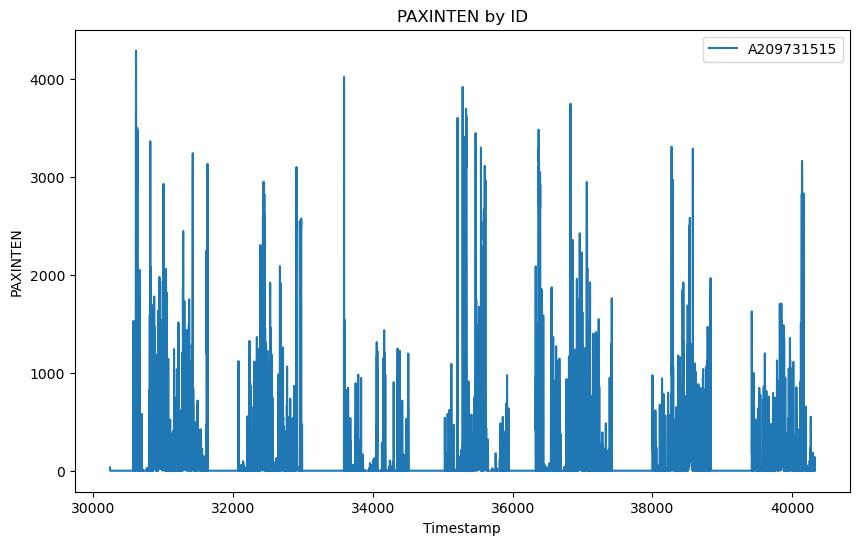

In [10]:
pam_combined_grouped = df.pam_combined.groupby('ID')
# Initialize the plot
plt.figure(figsize=(10, 6))
# Iterate over each group
for name, group in pam_combined_grouped:
    plt.plot(group.index.to_list(), group['PAXINTEN'].to_list(), label=name)
    print(name)
    break
# Adding titles and labels
plt.title('PAXINTEN by ID')
plt.xlabel('Timestamp')
plt.ylabel('PAXINTEN')
plt.legend()
#plt.legend(title='ID')
plt.show()

In [11]:
df.calculate_actigraphy()
df.compute_features()

Calculating Actigraphy Data from Synthetic Patients


## 5. Removing Acticraphy data and performing sampling for evenly distributed datasets 

- When using the BP_PHQ_9 as a depression classifier there the d_phq groups [0, 1, 2, 3, 6, 7, 8, 9]
- When using the MH_PHQ_S we have d_phq groups ranging from 0 -> 27
- We sample 80 out of each group in the d_phq Column using BP_PHQ_9 and 40 out of each group using MH_PHQ_S

In [ ]:
df.remove_actigraphy()
print(df.id_pairs_df.head())

         ID_1        ID_2                       group_id     SEX      AGE  \
0  A210768915  A212772312  Female_[19-23]_Healthy Weight  Female  [19-23]   
1  A210768915  A222753613  Female_[19-23]_Healthy Weight  Female  [19-23]   
2  A210768915  A223717913  Female_[19-23]_Healthy Weight  Female  [19-23]   
3  A210768915  A225750216  Female_[19-23]_Healthy Weight  Female  [19-23]   
4  A210768915  A232704313  Female_[19-23]_Healthy Weight  Female  [19-23]   

           HE_BMI           ID_COMBINED  d_PHQ  Depression  FEATURE_0  ...  \
0  Healthy Weight  A210768915A212772312    3.0           0   4.055122  ...   
1  Healthy Weight  A210768915A222753613    0.0           0   3.620907  ...   
2  Healthy Weight  A210768915A223717913    5.0           0   2.435839  ...   
3  Healthy Weight  A210768915A225750216    0.0           0   4.748615  ...   
4  Healthy Weight  A210768915A232704313    0.0           0   3.316127  ...   

   FEATURE_46  FEATURE_47  FEATURE_48  FEATURE_49  FEATURE_50  FEATU

Participant distribution before sampling

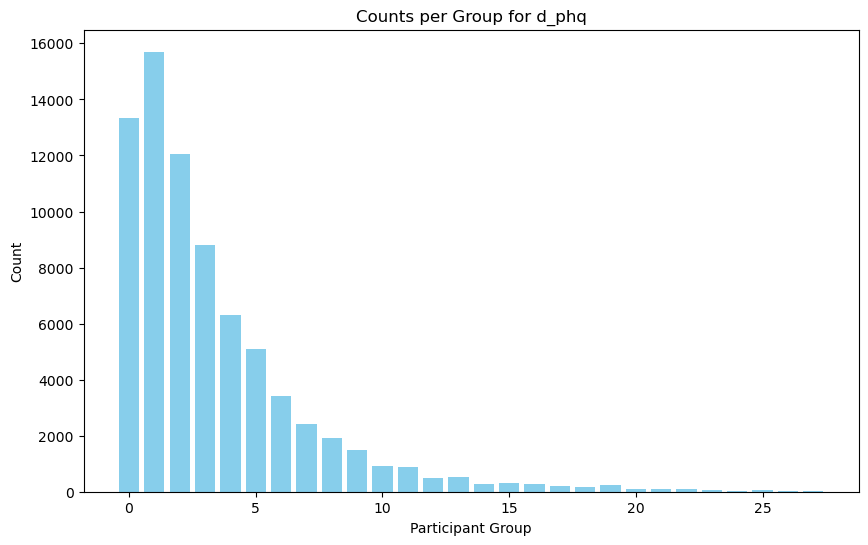

(75324, 65)


In [ ]:
df.particicipant_distribution()
print(df.id_pairs_df.shape)

In [ ]:
df.dataset_sample()

Participant distribution after sampling

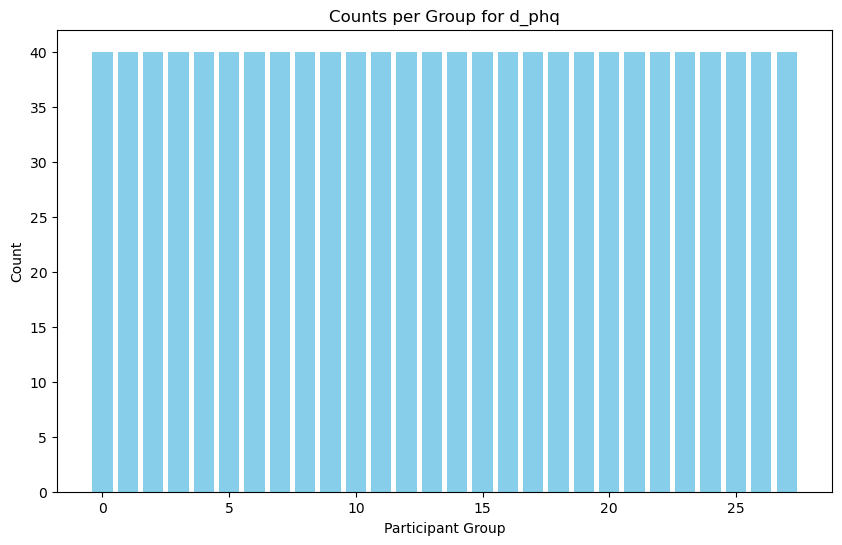

(1120, 65)


In [ ]:
df.particicipant_distribution()
print(df.id_pairs_df.shape)

Saving the dataframe as a csv into the data folder

In [ ]:
df.save_data(f'data/Threshold_{df.threshold}_Operator_{df.operator}_Depressionfeature_{df.depression_feature}_PercentofDataset_{df.percent}.csv')

Saving Data into data/Threshold_10_Operator_-_Depressionfeature_MH_PHQ_S_PercentofDataset_100.csv
